In [ ]:
# execute once to install the correct packages and their versions
# ! pip uninstall -y tensorflow
# ! pip uninstall -y tf-nightly
# ! pip install -q -U tensorflow-gpu=1.14.0

# ! pip install -q tensorflow-model-optimization

# ! pip uninstall -y keras==2.2.4
# ! pip install -q keras==2.1.6

In [2]:
# packages preloading
## packages for dataset and image preprocessing
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


## packages for modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras import regularizers
from keras.objectives import categorical_crossentropy
import math

## packages for pruning
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

## visualization & file saving
from matplotlib import pyplot as plt
import pickle 
import numpy as np
import os, sys


## version checking
print (keras.__version__)
print (tf.__version__)

2.2.4-tf
1.14.0


In [4]:
# Identify GPU 
tf.config.experimental.list_physical_devices('GPU') 
# Assign GPU
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
#CONFIG MEMORY USAGE
config = tf.ConfigProto() #device_count = {'GPU':1} 
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

## Loading Dataset

In [5]:
# function for data augmentation
def getDataGenerator(train_phase):
    if train_phase == True:
        datagen = ImageDataGenerator(
        rotation_range=0.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        channel_shift_range=0.,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None)
    else: 
        datagen = ImageDataGenerator(
        rescale=None
        )

    return datagen


### - Cifar100

In [6]:
# define DenseNet parms Cifar10
nb_classes = 100
img_dim = (32,32,3)

batch_size = 64
nb_epoch = 40

In [7]:
# datasets with data augmentation
(x_train,y_train),(x_test,y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test= keras.utils.to_categorical(y_test, nb_classes)

# hold out 5000 samples from training for validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size=0.1, random_state=42)

train_datagen = getDataGenerator(train_phase=True)
train_datagen = train_datagen.flow(x_train,y_train,batch_size = batch_size)

validation_datagen = getDataGenerator(train_phase=False)
validation_datagen = validation_datagen.flow(x_val,y_val,batch_size = batch_size)

In [8]:
print(x_train.shape,y_train.shape)
print(x_tr.shape,y_tr.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)


(50000, 32, 32, 3) (50000, 100)
(45000, 32, 32, 3) (45000, 100)
(5000, 32, 32, 3) (5000, 100)
(10000, 32, 32, 3) (10000, 100)


## Modeling

### Model Functions

In [9]:
# define chuncks of model 
def conv_layer(inputs,filters,kernel_size,strides,dropout_rate=None,weight_decay=1E-4):
    """single convolution 2D with pre-activation"""
  
    ## pre-activation BN and ReLU
    bn_axis = 1 if K.image_data_format() == "th" else -1
  
    x = layers.BatchNormalization(axis = bn_axis, epsilon=1.1e-5)(inputs)
    x = layers.Activation('relu')(x)
  
    ## conv2D layer with padding = 'same'
    outputs = layers.Conv2D(filters = filters, kernel_size = kernel_size,strides = strides, 
                            kernel_initializer="he_uniform", padding = 'same', use_bias=False,
                            kernel_regularizer = regularizers.l2(weight_decay))(x)
  
    ## dropout layer after convolutional layers except the first conv layer (for dataset without data augmentation)
    if dropout_rate is not None: 
        outputs = layers.Dropout(dropout_rate)(outputs)
  
    return outputs

def bottleneck_layer(inputs,filters):
    """bottleneck layer with pre-activation"""
    ## pre-activation BN and ReLU
    bn_axis = 1 if K.image_data_format() == "th" else -1
  
    x = layers.BatchNormalization(axis = bn_axis, epsilon=1.1e-5)(inputs)
    x = layers.Activation('relu')(x)
  
    ## conv2D layer with kernel size 1 x 1
    ### number of feature maps of bottleneck layer = 4k 
    nb_filter = 4 * filters
    outputs = layers.Conv2D(filters = nb_filter, kernel_size = (1,1),strides = (1,1), padding = 'same')(x)
  
    return outputs  

def conv_block(inputs,filters):
    """conv block consisting of a bottleneck layer and a convolution layer with kernel size 3x3"""
  
    kernel_size = (3,3)
    strides = (1,1)
  
    x = bottleneck_layer(inputs,filters)
    outputs = conv_layer(x,filters,kernel_size,strides)
    
  
    return outputs

def dense_block(inputs,nb_filter,growth_rate, nb_conv_block):
    """a convolutional block with multiple conv blocks and concatenation for outputs of each conv block 
       key innovation for DenseNet
    """
    concat_axis = 1 if K.image_data_format() == "th" else -1

    # x_list is created for storage purpose
    x_list = [inputs]
  
    for i in range(nb_conv_block):
        outputs = conv_block(inputs, growth_rate)
        x_list.append(outputs)
        inputs = layers.concatenate([inputs,outputs],concat_axis)
    
        nb_filter +=growth_rate

    return inputs,nb_filter,x_list

def transition_block(inputs,nb_filter,theta,dropout_rate):
    """a block that consists of one bottleneck conv layer and a pooling layer
       to furhter improve model compactness
    """
    
    #compression parameter to reduce number of channels/filters
    ## theta = 1 for no compression
    ## theta = 0.5 for DenseNet-BC
  
    x = conv_layer(inputs,math.floor(nb_filter * theta),(1,1),(1,1),dropout_rate)
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
  
    return x, math.floor(nb_filter * theta)

# define the model 
def DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay):
    """the actual DenseNet model"""
    ## The initial convolution layer comprises 2k convolutions of size 3 x 3 with stride 1
    x = conv_layer(inputs,init_nb_filters,(3,3),(1,1))

    ## Dense Block (1) + Transition Block (1)
    x,nb_filters,x_list_ = dense_block(x,init_nb_filters,growth_rate,nb_layers)
    x,nb_filters = transition_block(x, nb_filters,theta, dropout_rate)

    ## Dense Block (2) + Transition Block (2)
    x,nb_filters,x_list_ = dense_block(x,nb_filters,growth_rate,nb_layers)
    x,nb_filters = transition_block(x, nb_filters,theta, dropout_rate)

    ## Dense Block (3)
    x,nb_filters,x_list_ = dense_block(x,nb_filters,growth_rate,nb_layers)

    ## Global Average Pooling 
    x = layers.GlobalAveragePooling2D()(x)

    ## FC classification layer
    x = layers.Dense(nb_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.l2(weight_decay))(x)

    return x


### Model Hyperparameters

In [10]:
# hyperparameters
## growth rate =k 
growth_rate = 12


## initial number of output channels
### DenseNet-B: 16
### DenseNet-BC: 2 * growth_rate
init_nb_filters = 24


## same number of layers in each dense block
depth = 100
nb_layers = 16


## dropout rate 
### DenseNet with data augmentation
dropout_rate = None
### DenseNet without data augmentation
### dropout_rate = 0.2

## weight decay 
weight_decay=1E-4

## theta 
theta = 0.5

## Model Setup

### DenseNet-BC-100-12 with data augmentation
- dropout_rate = None


In [11]:
# DenseNet-BC setup

## input images 32 x 32
inputs = keras.Input(img_dim)

## call DenseNet-BC-100-12 with data augmentation
outputs = DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay)

## assign the actual model
model = keras.Model(inputs,outputs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.summary()

## Model Training

In [12]:
# training parameters
## define learning rate decay rule
def scheduler(epoch):
    """learning rate decay for 40 epoch
    - 50% of epoch: 0.1 
    50% -75% of epoch: 0.01 
    70% - of epoch: 0.001
    """
    if epoch < 20:
        return 0.1
    if epoch < 30:
        return 0.01
    return 0.001

In [ ]:
# actual training 
## define optimizer:SGD 
optimizer = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
## define callbacks
model_checkpoint = keras.callbacks.ModelCheckpoint('densenet_100_12.h5', monitor="val_acc", save_best_only=True,
                                  save_weights_only=True, verbose=1)

## set callback
change_lr = keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [change_lr,model_checkpoint]

## feed all settings into the model to train
history = model.fit_generator(generator=train_datagen,
                steps_per_epoch= x_tr.shape[0] // batch_size,
                epochs=nb_epoch,b
                callbacks=callbacks,
                validation_data=validation_datagen,
                validation_steps = x_val.shape[0] // batch_size,
                verbose=1)

In [ ]:
model.load_weights('./densenet_100_aug_40.h5')

# Model Compression

## Pruning

### Pruning Functions

In [15]:
def prune_after_training(model,percentile):

    num_layers = len(model.layers)

    for layer_idx in range(num_layers):
        if len(model.layers[layer_idx].weights) !=0:
            for weight_idx in range(len(model.layers[layer_idx].weights)):
                if (len(model.layers[layer_idx].weights[weight_idx].shape) == 4) or (len(model.layers[layer_idx].weights[weight_idx].shape)==2):
                    weight = model.layers[layer_idx].get_weights()[weight_idx]
                    weight_abs = np.absolute(weight)
                    value = np.percentile(weight_abs,percentile)
                    # pruning
                    ## create mask with percentage q of zeros
                    mask = np.ones((weight.shape))
                    mask[weight_abs <= value] = 0         
                    ## get pruned weight matrix and pass it to weight
                    pruned_weight = np.multiply(mask, weight)
                    K.set_value(model.layers[layer_idx].weights[weight_idx],pruned_weight)
    return model

def get_total_sparsity(model):
    
    total = 0
    zeros = 0
    for i, w in enumerate(model.get_weights()):
#         print(
#             "{} -- Total:{}, Zeros: {:.2f}%".format(
#                 model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
#             )
#         )
        total +=w.size
        zeros +=np.sum(w == 0)
    total_sparsity = zeros/total * 100
    return total_sparsity

### Direct Pruning

In [ ]:
testing_acc_list = []
sparsity_list = []

for value in range(0,100,5):
    model.load_weights('./densenet_100_aug_40.h5')
    model_pruned_after_training = prune_after_training(model,value)
    testing_acc = model_pruned_after_training.evaluate(x_test,y_test,batch_size)
    testing_acc_list.append(testing_acc)
    
    sparsity = get_total_sparsity(model_pruned_after_training)
    sparsity_list.append(sparsity)
    
    model_pruned_after_training.save_weights('./direct_pruned{}.h5'.format(value))

In [ ]:
testing_accuracy_list = [testing_acc_list[i][1] for i in range(len(testing_acc_list))]

In [ ]:
sparsity_list

In [ ]:
plt.axhline(y=0.7122, color='black', linestyle='--',label = 'no pruning')
plt.scatter(sparsity_list,testing_accuracy_list,s = 10, label = 'pruned after training')
plt.xlim([0,90])
plt.ylim([0,0.9])
plt.legend()
plt.xlabel('Total Parameters Pruned %')
plt.ylabel('Testing Accuracy')
plt.title('Direct Pruning')
plt.savefig('Direct Pruning corrected')

### Iterative Pruning

In [13]:
# sparsity level
## adjust it to run the next chunk
## (45,90)
value = 60

In [13]:
# DenseNet-BC setup
## input images 32 x 32
inputs = keras.Input(img_dim)
## call DenseNet-BC-100-12 with data augmentation
outputs = DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay)
## assign the actual model
model = keras.Model(inputs,outputs)

## define optimizer:SGD 
optimizer = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

model.load_weights('./densenet_100_aug_40.h5')
nb_epoch = 40
end_step = np.ceil(1.0 * 45000 / batch_size).astype(np.int32) * nb_epoch
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.0, final_sparsity= value/100,
                  begin_step=2000, end_step=end_step,frequency=100)

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)

optimizer = keras.optimizers.SGD(lr=.001, momentum=0.9, nesterov=True)
model_pruned.compile(
loss=tf.keras.losses.categorical_crossentropy,
optimizer=optimizer,
metrics=['accuracy'])
# actual training 
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard

#     model_checkpoint = keras.callbacks.ModelCheckpoint('./iter_pruning_{}.h5'.format(value), monitor="val_acc", save_best_only=False,
#                                   save_weights_only=True, verbose=1)
callbacks = [sparsity.UpdatePruningStep()]
## feed all settings into the model to train
history = model_pruned.fit_generator(generator=train_datagen,
                steps_per_epoch= x_tr.shape[0] // batch_size,
                epochs=nb_epoch,
                callbacks=callbacks,
                validation_data=validation_datagen,
                validation_steps = x_val.shape[0] // batch_size,
                verbose=1)    

model_pruned.save_weights('./iter_pruned_{}.h5'.format(value))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [16]:
#model_pruned.load_weights('./iter_pruned_{}.h5'.format(value))
# accuracy on test set using DenseNet-BC-100-12 pruned
acc_iter = model_pruned.evaluate(x_test,y_test,batch_size)

# get rid of extra parameters during pruning
final_model = sparsity.strip_pruning(model_pruned)
sparsity = get_total_sparsity(final_model)


10000/10000 [==============================] - 9s 850us/sample - loss: 1.4152 - acc: 0.7122


In [17]:
print(acc_iter,sparsity)

[1.4151958063125611, 0.7122] 0.0


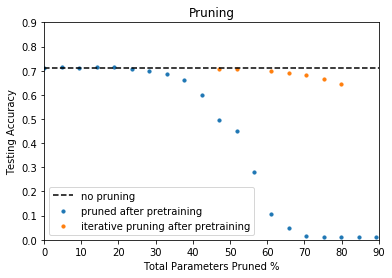

In [20]:
acc_iter_list_iter = [0.7085,0.7057,0.6995,0.6917,0.6810,0.6675,0.6463,0.5813]
sparsity_list_iter = [47,51.73,61.13,65.84,70.54,75.27,79.95,84.65]

testing_accuracy_list = [0.7122,0.7132,0.7123,0.7136,0.7147,0.7087,0.698,0.685,0.6603,0.5976,0.4962,0.4495,0.2801,0.108,0.05,0.0173,0.0105,0.0099,0.01,0.01]
sparsity_list = [0.01,4.71,9.41,14.11,18.81,23.51,28.22,32.92,37.62,42.33,47.03,51.73,56.43,61.13,65.80,70.54,75.24,79.94,84.64,89.35]

plt.axhline(y=0.7122, color='black', linestyle='--',label = 'no pruning')
plt.scatter(sparsity_list,testing_accuracy_list,s = 10, label = 'pruned after pretraining')
plt.scatter(sparsity_list_iter,acc_iter_list_iter,s = 10, label = 'iterative pruning after pretraining')
plt.xlim([0,90])
plt.ylim([0,0.9])
plt.legend()
plt.xlabel('Total Parameters Pruned %')
plt.ylabel('Testing Accuracy')
plt.title('Pruning')
plt.savefig('Iterative Pruning')

## Quantization

In [ ]:
def quantization(model,bits = 8):
    cluster_centers = []
    num_layers = len(model.layers)

    for layer_idx in range(num_layers):
        if len(model.layers[layer_idx].weights) !=0:
            for weight_idx in range(len(model.layers[layer_idx].weights)):
                # find conv and fc layer
                if (len(model.layers[layer_idx].weights[weight_idx].shape) == 4) or (len(model.layers[layer_idx].weights[weight_idx].shape) == 2):
                    #extract weight matrix
                    weight = model.layers[layer_idx].get_weights()[weight_idx]
                    #create mask matrix for weight matrix
                    mask = np.ones((weight.shape))
                    mask[weight ==0] = 0 
                    masked_weight = (weight * mask).flatten().reshape((-1,1)) #2D
                    
                    # shrink the weight 
                    weight_shrinked = masked_weight[masked_weight!=0].reshape((-1,1))
                    
                    # Apply K-means algorithm to find centroids
                    kmeans = KMeans(2**bits).fit(weight_shrinked)
                    cluster_centers_layer = kmeans.cluster_centers_.reshape(kmeans.cluster_centers_.shape[0])            
                    predicted_idx = kmeans.predict(masked_weight)

                    #assign centered weight value using index still 2D array
                    masked_weight = cluster_centers_layer[predicted_idx]

                    quantized_mask_weight = masked_weight.flatten().reshape(weight.shape) * mask
                    cluster_centers.append(cluster_centers_layer)
                    K.set_value(model.layers[layer_idx].weights[weight_idx],quantized_mask_weight)
    
    return model,cluster_centers

In [ ]:
# make sure change the value to run the next chunk of code
value = 80

In [ ]:
## input images 32 x 32
inputs = keras.Input(img_dim)
## call DenseNet-BC-100-12 with data augmentation
outputs = DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay)
## assign the actual model
model = keras.Model(inputs,outputs)

model.load_weights('./densenet_100_aug_40.h5')
nb_epoch = 40
end_step = np.ceil(1.0 * 45000 / batch_size).astype(np.int32) * nb_epoch
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.0, final_sparsity= value/100,
                  begin_step=2000, end_step=end_step,frequency=100)

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)

optimizer = keras.optimizers.SGD(lr=.001, momentum=0.9, nesterov=True)
model_pruned.compile(
loss=tf.keras.losses.categorical_crossentropy,
optimizer=optimizer,
metrics=['accuracy'])
   
model_pruned.load_weights('./iter_pruned_{}.h5'.format(value))

# get rid of extra parameters during pruning
final_model = sparsity.strip_pruning(model_pruned)

In [ ]:
quantized_model,centers = quantization(final_model,bits = 6)
# actual training 
## define optimizer:SGD 
optimizer = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
quantized_model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
acc_quan = quantized_model.evaluate(x_test,y_test,batch_size)
sparsity = get_total_sparsity(quantized_model)
print(acc_quan,sparsity)

## Huffman Coding

In [ ]:
def huffman_coding_per_layer(weight, centers):
    """
    Huffman coding for each layer
    :param weight: weight parameter of the current layer.
    :param centers: KMeans centroids in the quantization codebook of the current weight layer.
    :return: 
            'encodings': Encoding map mapping each weight parameter to its Huffman coding.
            'frequency': Frequency map mapping each weight parameter to the total number of its appearance.

    Generate Huffman Coding and Frequency Map according to incoming weights and centers (KMeans centriods).
    """
    weight = weight.flatten()
    weight = weight[weight!=0]
    frequency = {}
    
    for w in weight:
        if w not in frequency:
            frequency[w] = 0
        frequency[w] +=1
    
    encodings = {}
    
    nb_unique_w = len(frequency)
    freq_val = [(v,[k]) for k,v in frequency.items()]
    heapq.heapify(freq_val)
    
    while len(freq_val) > 1:
        tempa = heapq.heappop(freq_val)
        tempb = heapq.heappop(freq_val)
        
        for element in tempa[1]:
            if element not in encodings:
                encodings[element] = '0'
            else:
                encodings[element] = '0' + encodings[element]
        for element in tempb[1]:
            if element not in encodings:
                encodings[element] = '1'
            else:
                encodings[element] = '1' + encodings[element]
        
        temp = (tempa[0]+tempb[0],tempa[1]+tempb[1])
        heapq.heappush(freq_val,temp)  
    
    return encodings, frequency

In [ ]:
# make sure change the value to run the next chunk of code
value = 80

In [ ]:
## input images 32 x 32
inputs = keras.Input(img_dim)
## call DenseNet-BC-100-12 with data augmentation
outputs = DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay)
## assign the actual model
model = keras.Model(inputs,outputs)

model.load_weights('./densenet_100_aug_40.h5')
nb_epoch = 40
end_step = np.ceil(1.0 * 45000 / batch_size).astype(np.int32) * nb_epoch
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.0, final_sparsity= value/100,
                  begin_step=2000, end_step=end_step,frequency=100)

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)

optimizer = keras.optimizers.SGD(lr=.001, momentum=0.9, nesterov=True)
model_pruned.compile(
loss=tf.keras.losses.categorical_crossentropy,
optimizer=optimizer,
metrics=['accuracy'])
   
model_pruned.load_weights('./iter_pruned_{}.h5'.format(value))

In [ ]:
# illustration of huffman coding for the first convolutional layer
final_model = sparsity.strip_pruning(model_pruned)
quantized_model,centers = quantization(final_model,bits = 6)
weight = quantized_model.layers[3].get_weights()[0]
encodings,frequency = huffman_coding_per_layer(weight, centers[0])